In [1]:
from sklearn.datasets import fetch_openml 
import matplotlib.pyplot as plt
import tensorflow as tf

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

c:\Users\jawor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (70000, 784), y shape: (70000,)


In [3]:
import numpy as np
from gtda.plotting import plot_heatmap

im8_idx = np.flatnonzero(y == "0")[0] 
img8 = X[im8_idx].reshape(28, 28) 
plot_heatmap(img8)

In [4]:
from sklearn.model_selection import train_test_split
train_size, test_size = 1000, 300 # Reshape to (n_samples, n_pixels_x, n_pixels_y) 
X = X.reshape((-1, 28, 28)) 
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666 ) 
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}") 
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1000, 28, 28), y_train shape: (1000,)
X_test shape: (300, 28, 28), y_test shape: (300,)


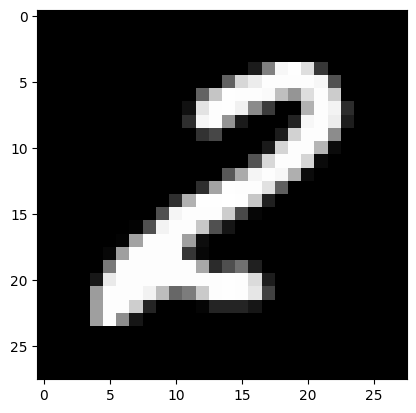

In [5]:
plt.imshow(X_test[5], cmap="gray")

C:\Users\jawor\AppData\Local\Temp\ipykernel_9656\1198908897.py:4: FutureWarning:

`seed` is a deprecated argument name for `random_noise`. It will be removed in version 0.23. Please use `rng` instead.

C:\Users\jawor\AppData\Local\Temp\ipykernel_9656\1198908897.py:5: FutureWarning:

`seed` is a deprecated argument name for `random_noise`. It will be removed in version 0.23. Please use `rng` instead.



Text(0.5, 1.0, 'Noisy Image with Random Noise')

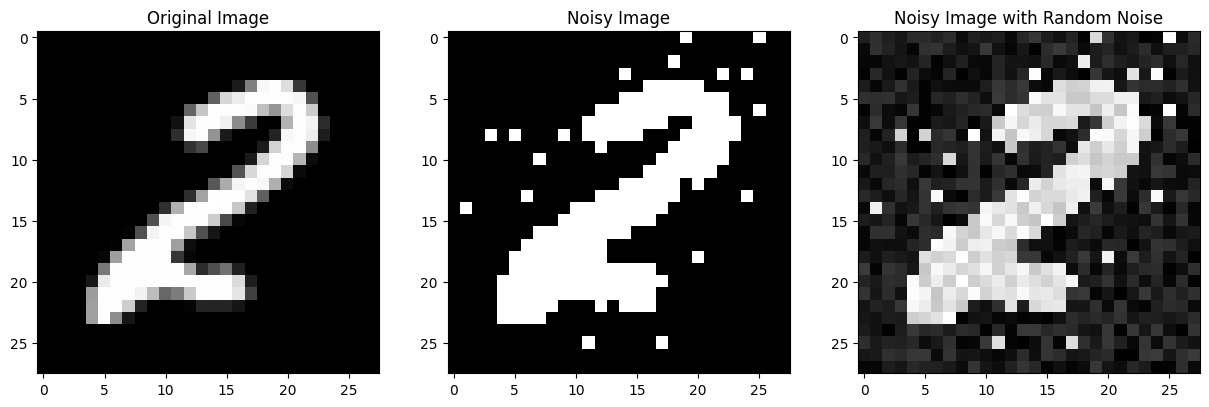

In [6]:
# distort X_train and X_test a little bit not using giotto

from skimage.util import random_noise
X_train_noisy = random_noise(X_train, mode="s&p",amount=0.05, seed=666)
X_test_noisy = random_noise(X_test, mode="s&p",amount=0.05, seed=666)

# generate random noise matrix of size X_train_noisy.shape and X_test_noisy.shape but without original image

X_train_noisy_random = np.random.rand(*X_train_noisy.shape)
X_test_noisy_random = np.random.rand(*X_test_noisy.shape)

# for each image in X_train_noisy and X_test_noisy, we will add the random noise matrix to the image

X_train_noisy_random = X_train_noisy + X_train_noisy_random
X_test_noisy_random = X_test_noisy + 0.3*X_test_noisy_random

# plot the original image, the noisy image and the noisy image with random noise

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(X_test[5], cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(X_test_noisy[5], cmap="gray")
ax[1].set_title("Noisy Image")
ax[2].imshow(X_test_noisy_random[5], cmap="gray")
ax[2].set_title("Noisy Image with Random Noise")






(300, 28, 28)


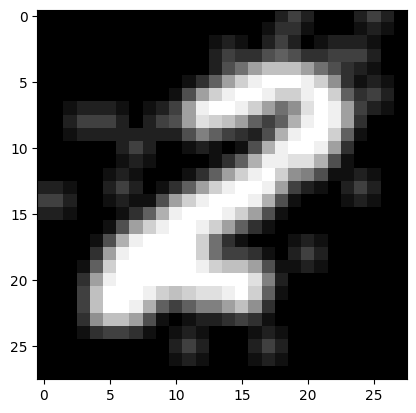

In [10]:
import cv2

X_test_noisy.shape

blurred = cv2.GaussianBlur(X_test_noisy[5], (3,3), 0) 
plt.imshow(blurred, cmap="gray")
print(X_test_noisy.shape)

In [11]:
from gtda.images import Binarizer 

# Pick out index of first 8 image 
im8_idx = np.flatnonzero(y_train == "8")[0] # Reshape to (n_samples, n_pixels_x, n_pixels_y) format 
im8 = X_train[im8_idx][None, :, :] 
binarizer = Binarizer(threshold=0.4) 
im8_binarized = binarizer.fit_transform(im8) 
binarizer.plot(im8_binarized)


In [12]:
from gtda.images import RadialFiltration, HeightFiltration
radial_filtration = RadialFiltration(center=np.array([20,6])) 
im8_filtration = radial_filtration.fit_transform(im8_binarized) 
radial_filtration.plot(im8_filtration, colorscale="jet")


In [13]:
from gtda.homology import CubicalPersistence 
cubical_persistence = CubicalPersistence(n_jobs=-1) 
im8_cubical = cubical_persistence.fit_transform(im8_filtration) 
cubical_persistence.plot(im8_cubical)


In [14]:
from gtda.diagrams import Scaler 
scaler = Scaler() 
im8_scaled = scaler.fit_transform(im8_cubical) 
scaler.plot(im8_scaled)


In [15]:
from gtda.diagrams import HeatKernel
heat = HeatKernel(sigma=.15, n_bins=28, n_jobs=-1) 
im8_heat = heat.fit_transform(im8_scaled) # Visualise the heat kernel for H1 
heat.plot(im8_heat, homology_dimension_idx=1, colorscale='jet')




In [16]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

In [17]:
from gtda.diagrams import HeatKernel, PersistenceImage, BettiCurve, PersistenceLandscape, Silhouette

In [18]:
from sklearn.pipeline import make_pipeline, make_union 
from gtda.diagrams import PersistenceEntropy 
from gtda.images import HeightFiltration 

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]] 
center_list = [ [13, 6], [6, 13], [13, 13], [20, 13], [13, 20], [6, 6], [6, 20], [20, 6], [20, 20], ] 

# Creating a list of all filtration transformer
filtration_list = (
    [ HeightFiltration(direction=np.array(direction), n_jobs=-1) for direction in direction_list ] +
    [ RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline 
diagram_steps = [
    [ Binarizer(threshold=0.4, n_jobs=-1), filtration, CubicalPersistence(n_jobs=-1), Scaler(n_jobs=-1), ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes 
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

# feature_union 
feature_union = make_union(
    PersistenceImage(sigma=.15, n_bins=28, n_jobs=-1) # or heat kernel, or possibly any other (but rational and well-fitting to model) vector representation of the diagram
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)


In [19]:
from sklearn import set_config 
set_config(display='diagram') 
tda_union


FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceimage',
                                                                                 Persisten...
                               ('pipeline-17',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('radialfiltration',
                                                 RadialFiltration(center=array([20, 20]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceimage',
                                                                                 PersistenceImage(n_bins=28,
                                                                                                  n_jobs=-1,
                                                                                                  sigma=0.15))]))]))])

In [20]:
X_train.shape

(1000, 28, 28)

In [21]:
X_train_tda_clean = tda_union.fit_transform(X_train)
print(X_train_tda_clean.shape)

X_test_tda_clean = tda_union.transform(X_test)
print(X_test_tda_clean.shape)


(1000, 34, 28, 28)
(300, 34, 28, 28)


In [269]:
X_train_tda_8 = tda_union.fit_transform(X_train_noisy_random) 
X_train_tda_8.shape




(1000, 34, 28, 28)

In [270]:
X_test_tda_8 = tda_union.transform(X_test_noisy_random)
X_test_tda_8.shape

(300, 34, 28, 28)

In [271]:
X_train_tda_good = np.transpose(X_train_tda_8, (0, 2, 3, 1))
X_test_tda_good = np.transpose(X_test_tda_8, (0, 2, 3, 1))

In [272]:
X_train_tda_clean_good = np.transpose(X_train_tda_clean, (0, 2, 3, 1))
X_test_tda_clean_good = np.transpose(X_test_tda_clean, (0, 2, 3, 1))
#shapes
#print(X_train_tda_good.shape)
#print(X_test_tda_good.shape)

In [273]:
X_test_tda_good.shape

(300, 28, 28, 34)

In [274]:
import tensorflow as tf

In [275]:
tf.keras.backend.clear_session()

In [289]:

model = tf.keras.models.Sequential()
#CNN
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 34)))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        9824      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 576)              

In [277]:
from tensorflow.keras.callbacks import EarlyStopping

In [278]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [290]:
# concat X_train_tda_good and 10% of X_train_tda_clean_good to get X_train_tda and concat y_train and y_train to get y_train_tda, then suffle them
X_train_tda = np.concatenate([X_train_tda_clean_good, X_train_tda_good[:100]], axis=0)
y_train_tda = np.concatenate([y_train, y_train[:100]], axis=0)

#shuffle
from sklearn.utils import shuffle
X_train_tda, y_train_tda = shuffle(X_train_tda, y_train_tda, random_state=666)


#shapes
print(X_train_tda.shape)
print(y_train_tda.shape)

#the same for raw data
X_train_alll = np.concatenate([X_train, X_train_noisy_random[:100]], axis=0)
y_train_alll = np.concatenate([y_train, y_train[:100]], axis=0)

#shuffle
X_train_alll, y_train_alll = shuffle(X_train_alll, y_train_alll, random_state=666)

#shapes
print(X_train_alll.shape)
print(y_train_alll.shape)

(1100, 28, 28, 34)
(1100,)
(1100, 28, 28)
(1100,)


In [291]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train_tda = y_train_tda.astype(int)

model.fit(X_train_tda, y_train_tda, epochs=20, batch_size=10, validation_data=(X_test_tda_good, y_test)) #callbacks=[early_stopping

Epoch 1/20
110/110 [==============================] - 7s 27ms/step - loss: 2.1062 - accuracy: 0.4309 - val_loss: 2.1734 - val_accuracy: 0.2200
Epoch 2/20
110/110 [==============================] - 3s 23ms/step - loss: 0.8922 - accuracy: 0.7264 - val_loss: 1.8966 - val_accuracy: 0.3733
Epoch 3/20
110/110 [==============================] - 3s 31ms/step - loss: 0.6413 - accuracy: 0.8009 - val_loss: 1.6902 - val_accuracy: 0.4367
Epoch 4/20
110/110 [==============================] - 2s 21ms/step - loss: 0.5568 - accuracy: 0.8309 - val_loss: 1.6136 - val_accuracy: 0.5100
Epoch 5/20
110/110 [==============================] - 2s 17ms/step - loss: 0.4358 - accuracy: 0.8600 - val_loss: 1.5427 - val_accuracy: 0.6000
Epoch 6/20
110/110 [==============================] - 2s 16ms/step - loss: 0.4349 - accuracy: 0.8609 - val_loss: 1.4582 - val_accuracy: 0.5300
Epoch 7/20
110/110 [==============================] - 2s 16ms/step - loss: 0.3165 - accuracy: 0.8991 - val_loss: 1.2820 - val_accuracy: 0.6167

KeyboardInterrupt: 

In [121]:
score_tda = model.evaluate(X_test_tda_good, y_test, verbose=1) # sprawdzenie na zaszumionych danych

10/10 [==============================] - 1s 20ms/step - loss: 2.4505 - accuracy: 0.4233


In [281]:
tf.keras.backend.clear_session()

In [294]:
# model standardowy bez tda
model2 = tf.keras.models.Sequential()
#CNN
model2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.3))

model2.add(tf.keras.layers.Dense(10, activation='softmax'))

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

model2.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_5 (Flatten)         (None, 576)              

In [295]:
# y_train_alll as int
y_train_alll = y_train_alll.astype(int)

In [296]:
# fit model2
model2.fit(X_train_alll, y_train_alll, epochs=20, batch_size=10, validation_data=(X_test_noisy_random, y_test)) # callbacks=[early_stopping]

Epoch 1/20
110/110 [==============================] - 6s 19ms/step - loss: 2.9827 - accuracy: 0.4491 - val_loss: 2.2867 - val_accuracy: 0.3400
Epoch 2/20
110/110 [==============================] - 2s 16ms/step - loss: 0.8296 - accuracy: 0.7336 - val_loss: 2.2858 - val_accuracy: 0.2600
Epoch 3/20
110/110 [==============================] - 3s 28ms/step - loss: 0.5879 - accuracy: 0.8055 - val_loss: 2.2732 - val_accuracy: 0.3933
Epoch 4/20
110/110 [==============================] - 3s 24ms/step - loss: 0.4134 - accuracy: 0.8755 - val_loss: 2.2599 - val_accuracy: 0.3833
Epoch 5/20
110/110 [==============================] - 3s 29ms/step - loss: 0.3733 - accuracy: 0.8836 - val_loss: 2.2418 - val_accuracy: 0.5100
Epoch 6/20
110/110 [==============================] - 2s 16ms/step - loss: 0.3267 - accuracy: 0.9027 - val_loss: 2.2175 - val_accuracy: 0.6633
Epoch 7/20
110/110 [==============================] - 2s 16ms/step - loss: 0.3592 - accuracy: 0.9045 - val_loss: 2.2186 - val_accuracy: 0.5767

KeyboardInterrupt: 

In [319]:
score2 = model2.evaluate(X_test_noisy_random, y_test) # sprawdzenie na zaszumionych danych 

10/10 [==============================] - 1s 13ms/step - loss: 2.2999 - accuracy: 0.1000


In [265]:
tf.keras.backend.clear_session()

In [369]:
# non convolutional model for standard mnist
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model3.add(tf.keras.layers.Dense(128, activation='relu'))
model3.add(tf.keras.layers.Dense(128, activation='relu'))

model3.add(tf.keras.layers.Dense(10, activation='softmax'))

model3.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
                metrics=['accuracy'])

model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               100480    
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [370]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# fit model3
model3.fit(X_train_alll, y_train_alll, epochs=20, batch_size=1, validation_data=(X_test_noisy_random, y_test)) #callbacks=[early_stopping]

Epoch 1/20
330/330 [==============================] - 6s 11ms/step - loss: 31.6669 - accuracy: 0.4242 - val_loss: 2.1003 - val_accuracy: 0.2367
Epoch 2/20
330/330 [==============================] - 5s 14ms/step - loss: 8.5348 - accuracy: 0.6545 - val_loss: 2.0647 - val_accuracy: 0.3667
Epoch 3/20
330/330 [==============================] - 4s 13ms/step - loss: 4.1722 - accuracy: 0.7606 - val_loss: 2.0625 - val_accuracy: 0.3167
Epoch 4/20
330/330 [==============================] - 5s 15ms/step - loss: 3.1545 - accuracy: 0.7879 - val_loss: 1.9930 - val_accuracy: 0.3733
Epoch 5/20
330/330 [==============================] - 5s 14ms/step - loss: 4.7366 - accuracy: 0.8424 - val_loss: 1.8797 - val_accuracy: 0.5200
Epoch 6/20
330/330 [==============================] - 4s 13ms/step - loss: 4.9716 - accuracy: 0.7879 - val_loss: 1.9111 - val_accuracy: 0.2633
Epoch 7/20
330/330 [==============================] - 5s 16ms/step - loss: 2.4294 - accuracy: 0.8939 - val_loss: 1.8811 - val_accuracy: 0.500

KeyboardInterrupt: 

In [275]:
score3 = model3.evaluate(X_test_noisy_random, y_test)

7/7 [==============================] - 0s 9ms/step - loss: 2.0246 - accuracy: 0.4350


In [282]:
from sklearn.pipeline import make_pipeline, make_union 
from gtda.diagrams import PersistenceEntropy 
from gtda.images import HeightFiltration 

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]] 
center_list = [ [13, 6], [6, 13], [13, 13], [20, 13], [13, 20], [6, 6], [6, 20], [20, 6], [20, 20], ] 

# Creating a list of all filtration transformer
filtration_list = (
    [ HeightFiltration(direction=np.array(direction), n_jobs=-1) for direction in direction_list ] +
    [ RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline 
diagram_steps = [
    [ Binarizer(threshold=0.4, n_jobs=-1), filtration, CubicalPersistence(n_jobs=-1), Scaler(n_jobs=-1), ]
    for filtration in filtration_list
]


# feature_union 
feature_union = make_union(
    *[PersistenceImage(sigma=.15, n_bins=28, n_jobs=-1),PersistenceImage(sigma=.05, n_bins=28, n_jobs=-1)] # or heat kernel, or possibly any other (but rational and well-fitting to model) vector representation of the diagram
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)
